In [7]:
import anndata as ad
import numpy as np
import scanpy as sc
import pandas as pd
from scipy.stats import spearmanr, pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import adjusted_rand_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from scipy.optimize import linear_sum_assignment

import sys
sys.path.append('..')
from src.interface import UnitedNet
from src.configs import *
import copy as copy


In [8]:
def partitions(celltype, n_partitions, seed=0):
    """
    adapted from https://github.com/AllenInstitute/coupledAE-patchseq
    """
    import warnings
    warnings.filterwarnings("ignore", category=UserWarning)

    # Safe to ignore warning - there are celltypes with a low sample number that are not crucial for the analysis.
    with warnings.catch_warnings():
        skf = StratifiedKFold(n_splits=n_partitions, random_state=seed, shuffle=True)

    # Get all partition indices from the sklearn generator:
    ind_dict = [{'train': train_ind, 'val': val_ind} for train_ind, val_ind in
                skf.split(X=np.zeros(shape=celltype.shape), y=celltype)]
    return ind_dict
    
def save_umap(adata_all,label,test_batch,nametype):
  fig,ax = plt.subplots(figsize=(6,4))
  ax=sc.pl.umap(adata_all,color=label, ax=ax,show=False)
  fig.savefig(root_save_path+f'/plot/{test_batch}_{nametype}_{label}.png',dpi=300)
  

def generate_adata(data, nonnan_indices, cell_type_label, cols, rows, batch):
    data = data.loc[data.index[nonnan_indices]]
    adata=ad.AnnData(X=np.array(data),obs=list(data.index))
    adata.obs['label']  = cell_type_label
    adata.obs['imagecol'] = cols
    adata.obs['imagerow'] = rows
    adata.obs['batch']  = batch
    return adata


def ordered_cmat(labels, pred):
    """
    Compute the confusion matrix and accuracy corresponding to the best cluster-to-class assignment.

    :param labels: Label array
    :type labels: np.array
    :param pred: Predictions array
    :type pred: np.array
    :return: Accuracy and confusion matrix
    :rtype: Tuple[float, np.array]
    """
    cmat = confusion_matrix(labels, pred)
    ri, ci = linear_sum_assignment(-cmat)
    ordered = cmat[np.ix_(ri, ci)]
    acc = np.sum(np.diag(ordered))/np.sum(ordered)
    return acc, ordered

def assignmene_align(labels1,labels2):
    C_e_types = confusion_matrix(labels1, labels2)
    #Assign labels of clusters based on 'best match' with transcriptomic celltype label
    row_ind,col_ind = linear_sum_assignment(-C_e_types)
    order_2 = np.unique(labels2)[col_ind]
    labels2_matched = copy.deepcopy(labels2)
    for name, orig_name in zip(np.unique(labels2),order_2):
        ind = labels2 == orig_name
        labels2_matched[ind] = name
    return labels2_matched

In [9]:
def pre_ps(adata_rna_raw,adata_ephys_raw,adata_morph_raw,cv,split=False):
  adata_rna,adata_ephys,adata_morph = adata_rna_raw.copy(),adata_ephys_raw.copy(),adata_morph_raw.copy()
  adatas_train,adatas_test = [],[]
  assert (adata_rna.X>=0).all(), "poluted input"
  for mod in [adata_rna,adata_ephys,adata_morph]:
    mod.obs['label'] = mod.obs['cell_type_TEM']
    if split:
      m_train = mod[ind_dict[cv]['train']]
      scaler = preprocessing.StandardScaler().fit(m_train.X)
      m_train.X = scaler.transform(m_train.X)

      m_test = mod[ind_dict[cv]['val']]
      scaler = preprocessing.StandardScaler().fit(m_test.X)
      m_test.X = scaler.transform(m_test.X)
    else:
      scaler = preprocessing.StandardScaler().fit(mod.X)
      mod.X = scaler.transform(mod.X)
      m_train = mod[ind_dict[cv]['train']]
      m_test = mod[ind_dict[cv]['val']]

    adatas_train.append(m_train)
    adatas_test.append(m_test)
  adatas_all = [ad.concat([m_train,m_test]) for m_train,m_test in zip(adatas_train,adatas_test)]
  return adatas_train,adatas_test,adatas_all

# load input patch-seq data

In [10]:
technique = 'patchseq'
data_path = f"../data/{technique}"
device = "cuda:0"
root_save_path = f"../saved_results/{technique}"
#load data
adata_rna_raw = sc.read_h5ad(f'{data_path}/adata_RNA_TEM.h5ad')
adata_ephys_raw = sc.read_h5ad(f'{data_path}/adata_Ephys_TEM.h5ad')
adata_morph_raw = sc.read_h5ad(f'{data_path}/adata_Morph_TEM.h5ad')
ind_dict = partitions(adata_rna_raw.obs['cell_type_TEM'], n_partitions=10, seed=0)


In [1]:
for cv in range(10):
  adatas_train,adatas_test,_ = pre_ps(adata_rna_raw,adata_ephys_raw,adata_morph_raw,cv,split=True)
  root_save_path = f"./saved_results/{technique}_{cv}"
  model = UnitedNet(root_save_path, device=device, technique=patchseq_config)
  model.train(adatas_train,adatas_val = adatas_test)

  print(model.evaluate(adatas_test))
  _,_,adatas_all = pre_ps(adata_rna_raw,adata_ephys_raw,adata_morph_raw,cv,split=False)
  model.load_model(f"{root_save_path}/train_best.pt")
  model.model.config['train_task'] = "unsupervised_group_identification"
  model.model.config['train_epochs'] = 20
  model.train(adatas_all,verbose=True,init_classify=True)
  
  

In [2]:
print('==============best finetune================')
model.load_model(f"{root_save_path}/train_best.pt")
model.evaluate(adatas_all,give_losses=True,stage="train")


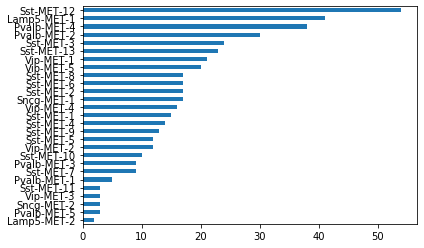

In [ ]:
ct_df = pd.DataFrame({'ct':adatas_all[0].obs['cell_type_TEM'].values})#,'ct_less':cell_type_less
plt.figure()
ct_df.ct.value_counts().sort_values().plot(kind = 'barh')


In [ ]:

model.load_model(f"{root_save_path}/train_best.pt")
losses = model.evaluate(adatas_all,give_losses=True,stage='train')
predict_label = model.predict_label(adatas_all)
adata_fused = model.infer(adatas_all)
adata_fused.obs['label'] = list(adatas_all[0].obs['label'])
adata_fused.obs['label_less'] = [ct.split('-')[0] for ct in adata_fused.obs['label'].values]


/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [ ]:
from sklearn.utils.multiclass import unique_labels


pseudo_label = np.array(adata_fused.obs['predicted_label'].values)
cmat = confusion_matrix(adata_fused.obs['label'], pseudo_label)
ri, ci = linear_sum_assignment(-cmat)
ordered_all = cmat[np.ix_(ri, ci)]
major_sub_names = {}
pred_labels_re_order = copy.deepcopy(pseudo_label)
for re_oder,(lb_correct,lb) in enumerate(zip(unique_labels(adata_fused.obs['label'], pseudo_label)[ri],
                                unique_labels(adata_fused.obs['label'], pseudo_label)[ci])):
  idx = pseudo_label==lb
  if any(idx):
    nm = '-'.join(lb_correct.split('-')[:-1])
    if nm in major_sub_names.keys():
      major_sub_names[nm]+=1
    else:
      major_sub_names[nm]=1
    
    pred_labels_re_order[idx] = f'{nm}-{major_sub_names[nm]}-Uni'#f'{lb_correct}-Uni'#

adata_fused.obs['predicted_label'] = pred_labels_re_order


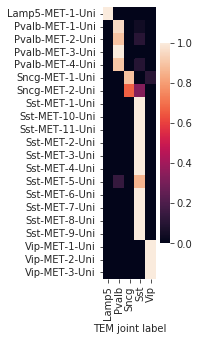

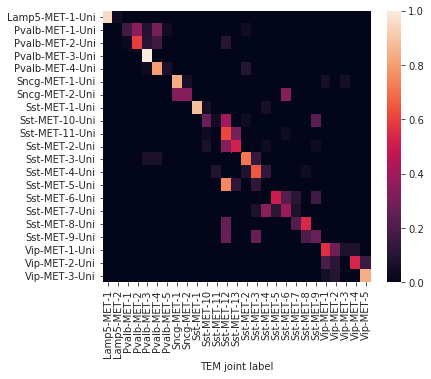

In [ ]:
sns.set_style('ticks')
adata_fused.obs['predicted_label_less'] = [ct.split('-')[0] for ct in adata_fused.obs['predicted_label'].values]
cmat = confusion_matrix(adata_fused.obs['predicted_label'], adata_fused.obs['label_less'])
cmat = cmat[:,cmat.sum(axis=0)!=0]
cmat = cmat[cmat.sum(axis=1)!=0,:]
cmat = (cmat.T / cmat.sum(axis=1)).T

fig,ax = plt.subplots(figsize=[1.2,5])
sns.heatmap(cmat,ax=ax,yticklabels=unique_labels(adata_fused.obs['predicted_label']),xticklabels=unique_labels(adata_fused.obs['label_less']),vmin=0, vmax=1)
plt.xlabel('TEM joint label')
plt.savefig('./figures/major_matching_heatmap.pdf')

fig,ax = plt.subplots(figsize=[6,5])
ordered = ordered_all[:,ordered_all.sum(axis=0)!=0]
ordered = ordered[ordered.sum(axis=1)!=0,:]
ordered_re = ordered.T
ordered_norm = (ordered_re.T / ordered_re.sum(axis=1)).T

sns.heatmap(ordered_norm,ax=ax,xticklabels=unique_labels(adata_fused.obs['label']),yticklabels=unique_labels(adata_fused.obs['predicted_label']),vmin=0, vmax=1)
plt.xlabel('TEM joint label')
plt.savefig('./figures/sub_matching_heatmap.pdf')





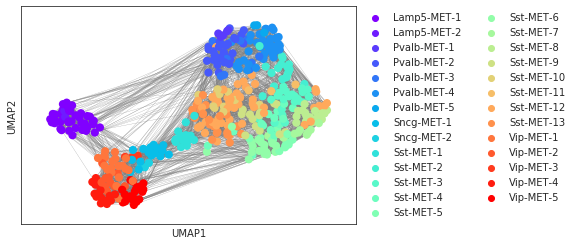

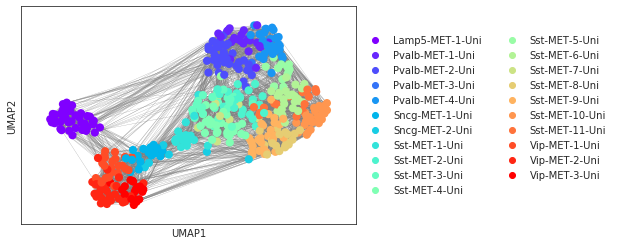

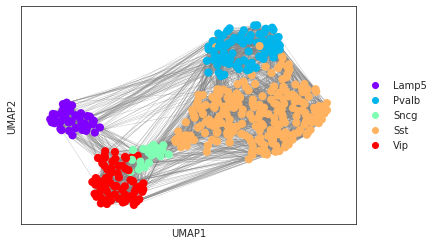

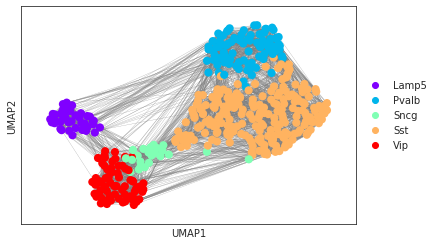

In [ ]:

sc.pl.umap(adata_fused,color=['label'],palette='rainbow',show=True,edges=True,edges_width = 0.2,linewidth=1000,edgecolors='k',title='',save='patch_seq_2D_orig_MET.pdf')
sc.pl.umap(adata_fused,color=['predicted_label'],palette='rainbow',show=True,edges=True,edges_width = 0.2,linewidth=1000,edgecolors='k',title='',save='patch_seq_2D_Uni_MET.pdf')


sc.pl.umap(adata_fused,color=['label_less'],palette='rainbow',show=True,edges=True,edges_width = 0.2,linewidth=1000,edgecolors='k',title='',save='patch_seq_2D_MET_comparison.pdf')
sc.pl.umap(adata_fused,color=['predicted_label_less'],palette='rainbow',show=True,edges=True,edges_width = 0.2,linewidth=1000,edgecolors='k',title='',save='patch_seq_2D_MET_comparison_no_legend.pdf')
